In [19]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.stats import pearsonr
import GRNgene as gg
import cma
import numpy as np
import pickle as pkl
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
random.seed(1)

In [20]:
def create_graph(species: list) -> nx.DiGraph:
    """
    Creates a directed graph from gene interactions for a given species.

        Args:
            - species (list): A list containing two lists:
            [gene_list, interaction_list]

        Returns:
            nx.DiGraph: A directed graph representing gene interactions.
    """
    N = len(species[0])  # Number of gene interactions
    Graph = nx.DiGraph()  # Create an empty directed graph
    for i in range(N):
        Graph.add_edge(species[0][i], species[1][i])  # Add edges to the graph
    return Graph

def remove_nan_values(species: list) -> None:
    """
    Removes NaN values from the end of the gene and interaction lists of
    a species.

        Args:
            - species (list): A list containing two lists:
            [gene_list, interaction_list]
    """
    # Check if the last element is not a string (i.e., it's NaN)
    while type(species[0][-1]) is not str:
        species[0].pop()  # Remove the last gene entry
        species[1].pop()  # Remove the corresponding interaction entry

def plot_degrees(
    G: nx.DiGraph,
    plot_fit: bool = False
):
    """
    Plot the total, in- and out- degree distribution of a network and optionally fit a power law.

    Parameters
    ----------
    G : nx.DiGraph
        Directed graph representing the gene regulatory network.
    
    plot_fit : bool, optional (default=False)
        If True, fit and overlay a power-law curve on the degree distribution plot.
        
    Returns
    -------
    None
        Displays the plots and prints the fitted power law parameters if `plot_fit` is True.
    """
    N = G.number_of_nodes()
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    degree_counts = np.unique(degree_sequence, return_counts=True)
    degrees = degree_counts[0]
    counts = degree_counts[1]
    probabilities = counts / N
               
    in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
    in_dmax = max(in_degree_sequence)
    in_degree_counts = np.unique(in_degree_sequence, return_counts=True)
    in_degrees = in_degree_counts[0]
    in_counts = in_degree_counts[1]
    in_probabilities = in_counts / N

    out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
    out_dmax = max(out_degree_sequence)
    out_degree_counts = np.unique(out_degree_sequence, return_counts=True)
    out_degrees = out_degree_counts[0]
    out_counts = out_degree_counts[1]
    out_probabilities = out_counts / N
    
    fig = plt.figure("Degree distribution", figsize=(8, 8))
    axgrid = fig.add_gridspec(3, 2)

    # Total degree
    ax0 = fig.add_subplot(axgrid[0, 0])
    mask = degrees > 0
    ax0.scatter(np.log(degrees[mask]), np.log(probabilities[mask]), marker="o", color="b")
    ax0.set_title("log-log Degree Distribution")
    ax0.set_ylabel("log P(k)")
    ax0.set_xlabel("log Degree k")
    
    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, degrees[degrees > 0], probabilities[degrees > 0])
        ax0.plot(
            np.log(degrees[degrees > 0]),
            np.log(power_law(degrees[degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax0.legend()
    
    # Degree histogram
    ax1 = fig.add_subplot(axgrid[0, 1])
    ax1.bar(degrees, counts)
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Number of Nodes")

    # In-degree
    ax2 = fig.add_subplot(axgrid[1, 0])
    in_mask = in_degrees > 0
    ax2.scatter(np.log(in_degrees[in_mask]), np.log(in_probabilities[in_mask]), marker="o", color="b")
    ax2.set_title("Log-Log In-Degree Distribution")
    ax2.set_ylabel("Log P(k)")
    ax2.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, in_degrees[in_degrees > 0], in_probabilities[in_degrees > 0])
        ax2.plot(
            np.log(in_degrees[in_degrees > 0]),
            np.log(power_law(in_degrees[in_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax2.legend()

    # Degree histogram
    ax2 = fig.add_subplot(axgrid[1, 1])
    ax2.bar(in_degrees, in_counts)
    ax2.set_title("Degree Histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Number of Nodes")
    
    # Out-degree
    ax3 = fig.add_subplot(axgrid[2, 0])
    out_mask = out_degrees > 0
    ax3.scatter(np.log(out_degrees[out_mask]), np.log(out_probabilities[out_mask]), marker="o", color="b")
    ax3.set_title("Log-Log Out-Degree Distribution")
    ax3.set_ylabel("Log P(k)")
    ax3.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, out_degrees[out_degrees > 0], out_probabilities[out_degrees > 0])
        ax3.plot(
            np.log(out_degrees[out_degrees > 0]),
            np.log(power_law(out_degrees[out_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax3.legend()

    # Degree histogram
    ax4 = fig.add_subplot(axgrid[2, 1])
    ax4.bar(out_degrees, out_counts)
    ax4.set_title("Out-Degree Histogram")
    ax4.set_xlabel("Degree")
    ax4.set_ylabel("Number of Nodes")

    fig.tight_layout()
    plt.show()

    if params is not None:
        print(f"Fitted power law parameters: a = {params[0]:.2f}, b = {params[1]:.2f}")

def power_law(x, a, b):
    return a * np.power(x, b)

def weighted_total_score(true_network, synthetic_network):
    degree_dist_true = np.array([d for _, d in true_network.degree()])
    degree_dist_synth = np.array([d for _, d in synthetic_network.degree()])
    ks_total = ks_2samp(degree_dist_true, degree_dist_synth)

    in_degree_dist_true = np.array([d for _, d in true_network.in_degree()])
    in_degree_dist_synth = np.array([d for _, d in synthetic_network.in_degree()])
    ks_in = ks_2samp(in_degree_dist_true, in_degree_dist_synth)

    out_degree_dist_true = np.array([d for _, d in true_network.out_degree()])
    out_degree_dist_synth = np.array([d for _, d in synthetic_network.out_degree()])
    ks_out = ks_2samp(out_degree_dist_true, out_degree_dist_synth)

    edge_true = true_network.number_of_edges()
    edge_synth = synthetic_network.number_of_edges()
    edge_diff = (edge_true - edge_synth)/edge_true

    avg_clustering_1 = nx.average_clustering(true_network)
    avg_clustering_2 = nx.average_clustering(synthetic_network)
    avg_clustering_diff = (avg_clustering_1 - avg_clustering_2)**2
    
    avg_degree_1 = sum(dict(true_network.degree()).values()) / true_network.number_of_nodes
    avg_degree_2 = sum(dict(synthetic_network.degree()).values()) / synthetic_network.number_of_nodes
    avg_degree_diff = (avg_degree_1 - avg_degree_2)**2

    # Weights
    w_ks_total = 0.25
    w_ks_in = 0.15
    w_ks_out = 0.15
    w_edge = 0.25
    w_cluster = 0.1
    w_degree = 0.1

    return (
        w_ks_total * ks_total +
        w_ks_in * ks_in +
        w_ks_out * ks_out +
        w_edge * edge_diff +
        w_cluster * avg_clustering_diff +
        w_degree * avg_degree_diff
    )

def evaluate_lfr(true_network, params):
    tau1, tau2, mu, hub_bias, min_community, max_community, average_degree = params

    try:
        LFR_params = dict(
        n=true_network.number_of_nodes(),
        tau1=tau1,
        tau2=tau2,
        mu=mu,

        average_degree=average_degree,
        min_community=min_community,
        max_community=max_community,
        hub_bias = hub_bias,
        seed=None
        )
        
        G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

        G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
            G_lfr,
            autoRG=0.0,   # self-loop probability
            duoRG=0.005    # bidirectional edge probability
        )
        print(f"Computing score...")
        # Compare distributions
        score = total_score(true_network, G_lfr_directed[0])
        print(f"Score: {score}")
        return score

    except Exception:
        return np.inf  # penalize failures


# Load

In [21]:
document = pd.read_excel("../../data/41598_2021_3625_MOESM5_ESM.xlsx")

# Load the data for different species from the Excel file
arabidopsisThaliana = (document["""Supplementary Table S1: Networks. A spreadsheet file with filtered networks"""].tolist()[2:], document["Unnamed: 1"].tolist()[2:], "Arabidopsis thaliana")  # noqa : E501
drosophilaMelanogaster = (document["Unnamed: 2"].tolist()[2:], document["Unnamed: 3"].tolist()[2:], "Drosophila Melanogaster")  # noqa : E501
escherichniaColi = (document["Unnamed: 4"].tolist()[2:], document["Unnamed: 5"].tolist()[2:], "Escherichnia coli")  # noqa : E501
homoSapiens = (document["Unnamed: 6"].tolist()[2:], document["Unnamed: 7"].tolist()[2:], "Homo sapiens")  # noqa : E501
saccharomycesCerevisiae = (document["Unnamed: 8"].tolist()[2:], document["Unnamed: 9"].tolist()[2:], "Saccharomyces cerevisiae")  # noqa : E501

remove_nan_values(homoSapiens)
g_hsapiens = create_graph(homoSapiens)
largest_weakly_cc = max(nx.weakly_connected_components(g_hsapiens), key=len)

hsapiens_largest = g_hsapiens.subgraph(largest_weakly_cc).copy()
largest_human_properties = gg.network_properties(hsapiens_largest)

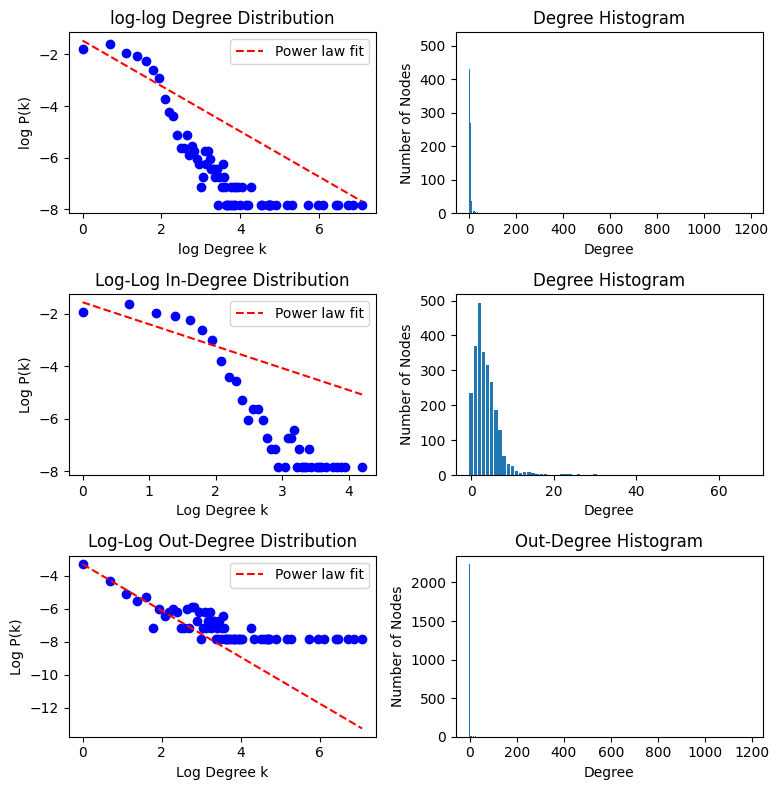

Fitted power law parameters: a = 0.04, b = -1.40


{'avg_clustering': 0.11280901692863012,
 'avg_degree': 7.552579755809374,
 'degrees': array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   34,
          35,   36,   37,   38,   39,   40,   42,   43,   44,   46,   47,
          48,   49,   52,   54,   57,   63,   67,   72,   92,   94,  110,
         113,  114,  116,  118,  134,  176,  200,  306,  390,  448,  617,
         651,  830,  956, 1193]),
 'density': 0.0014878998730908932,
 'degree_proba': array([0.16935801, 0.20283576, 0.14178811, 0.12760929, 0.10594722,
        0.07325719, 0.05317054, 0.02363135, 0.01457267, 0.01260339,
        0.00590784, 0.0035447 , 0.0035447 , 0.00590784, 0.00275699,
        0.00393856, 0.00315085, 0.00236314, 0.00196928, 0.00078771,
        0.00118157, 0.00315085, 0.00196928, 0.00315085, 0.00236314,
        0.00157542, 0.00157542, 0.00157542, 0.

In [22]:
plot_degrees(hsapiens_largest, plot_fit=True)
largest_human_properties

# Optimization

In [23]:
import cma

# CMA-ES initial guess (tau1, tau2, mu, hub_bias, min_community, max_community)
x0 = [2.11905595, 1.20991633, 0.50243064, 3.14983374, 5.10054852, 500.4941408, 7.5]
sigma0 = 0.1  # Initial standard deviation

es = cma.CMAEvolutionStrategy(x0, sigma0, {'bounds': [[1.5, 1.1, 0.05, 1, 2, 1, 5], [5.0, 3.0, 0.85, 5, 50, 2000, 10]]})

history = []

while not es.stop():
    candidates = es.ask()
    fitnesses = [evaluate_lfr(hsapiens_largest, candidate) for candidate in candidates]
    for s, f in zip(candidates, fitnesses):
        history.append({'params': s, 'score': f})
    es.tell(solutions, fitnesses)
    es.logger.add()
    es.disp()
    # # Save progress
    # if es.countiter % 5 == 0:
    #     with open("cma_checkpoint.pkl", "wb") as f:
    #         pkl.dump(es, f)
    #     pd.DataFrame(history).to_csv("cma_history.csv", index=False)



(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=706117, Mon Jun 23 10:01:29 2025)
Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Generation failed on attempt 3, retrying...
Generation failed on attempt 4, retrying...
Generation failed on attempt 5, retrying...
Generation failed on attempt 6, retrying...
Generation failed on attempt 7, retrying...
Generation failed on attempt 8, retrying...
Generation failed on attempt 9, retrying...
Generation failed on attempt 10, retrying...
Generation failed on attempt 11, retrying...
Generation failed on attempt 12, retrying...
Generation failed on attempt 13, retrying...
Generation failed on attempt 14, retrying...
Generation failed on attempt 15, retrying...
Generation failed on attempt 16, retrying...
Generation failed on attempt 17, retrying...
Generation failed on attempt 18, retrying...
Generation failed on attempt 19, retrying...
Generation failed on attempt 20, retrying...
Computing score...


/opt/conda/envs/venv_modelinf/lib/python3.10/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 23 10:28:31 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/opt/conda/envs/venv_modelinf/lib/python3.10/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Generation failed on attempt 3, retrying...
Generation failed on attempt 4, retrying...
Generation failed on attempt 5, retrying...
Generation failed on attempt 6, retrying...
Computing score...
Computing score...
Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Computing score...
Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Generation failed on attempt 3, retrying...
Generation failed on attempt 4, retrying...
Generation failed on attempt 5, retrying...
Generation failed on attempt 6, retrying...
Generation failed on attempt 7, retrying...
Generation failed on attempt 8, retrying...
Generation failed on attempt 9, retrying...
Generation failed on attempt 10, retrying...
Generation failed on attempt 11, retrying...
Generation failed on attempt 12, retrying...
Generation failed on attempt 13, retrying...
Generation fail

/opt/conda/envs/venv_modelinf/lib/python3.10/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 23 10:58:28 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


In [24]:
best_params = es.result.xbest
print("Best parameters:", best_params)

Best parameters: None


# Initial parameter trials

In [28]:
tau1, tau2, mu, hub_bias, min_community, max_community = [2.11905595, 1.20991633, 0.50243064, 3.14983374, 5.10054852, 500.4941408]

LFR_params = dict(
n=largest_human_properties['nb_nodes'],
tau1=tau1,
tau2=tau2,
mu=mu,
seed=None,
average_degree=7.5,
min_community=min_community,
max_community=max_community,
hub_bias = hub_bias
)

G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

gg.network_properties(G_lfr_directed[0])

Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Generation failed on attempt 3, retrying...


{'avg_clustering': 0.06442625794709167,
 'avg_degree': 12.513588026782198,
 'degrees': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  43,  44,  45,  47,  49,  53,  54,  55,  57,  58,  59,  62,
         63,  64,  67,  69,  73,  74,  78,  81,  82,  84,  86,  88,  90,
         95,  98, 106, 107, 109, 114, 115, 116, 121, 125, 129, 138, 155,
        159, 165, 171, 180, 208, 214, 252, 273, 276, 363, 373, 383, 432,
        476, 613, 752]),
 'density': 0.0024652458681604012,
 'degree_proba': array([0.00787712, 0.03072076, 0.05632139, 0.09925167, 0.12051989,
        0.14100039, 0.12445845, 0.1008271 , 0.06971249, 0.05395825,
        0.0338716 , 0.02087436, 0.01811737, 0.00945254, 0.00787712,
        0.0098464 , 0.00787712, 0.00669555, 0.00748326, 0.00669555,
        0.00393856, 0.00275699, 0.0035447 , 0.00315085,

# GRNgene

In [26]:
tau1, tau2, mu, hub_bias, min_community, max_community, avg_degree = best_params

LFR_params = dict(
n=3554,#hsapiens_largest.number_of_nodes(),
tau1=tau1,
tau2=tau2,
mu=mu,
seed=None,
average_degree=avg_degree,
min_community=min_community,
max_community=max_community,
hub_bias = hub_bias
)

G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

gg.network_properties(G_lfr_directed[0])

TypeError: cannot unpack non-iterable NoneType object